In [43]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier

rs = 42

In [252]:
df_raw = pd.read_csv("healthcare-dataset-stroke-data.csv")
df_raw.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [224]:
df_raw.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


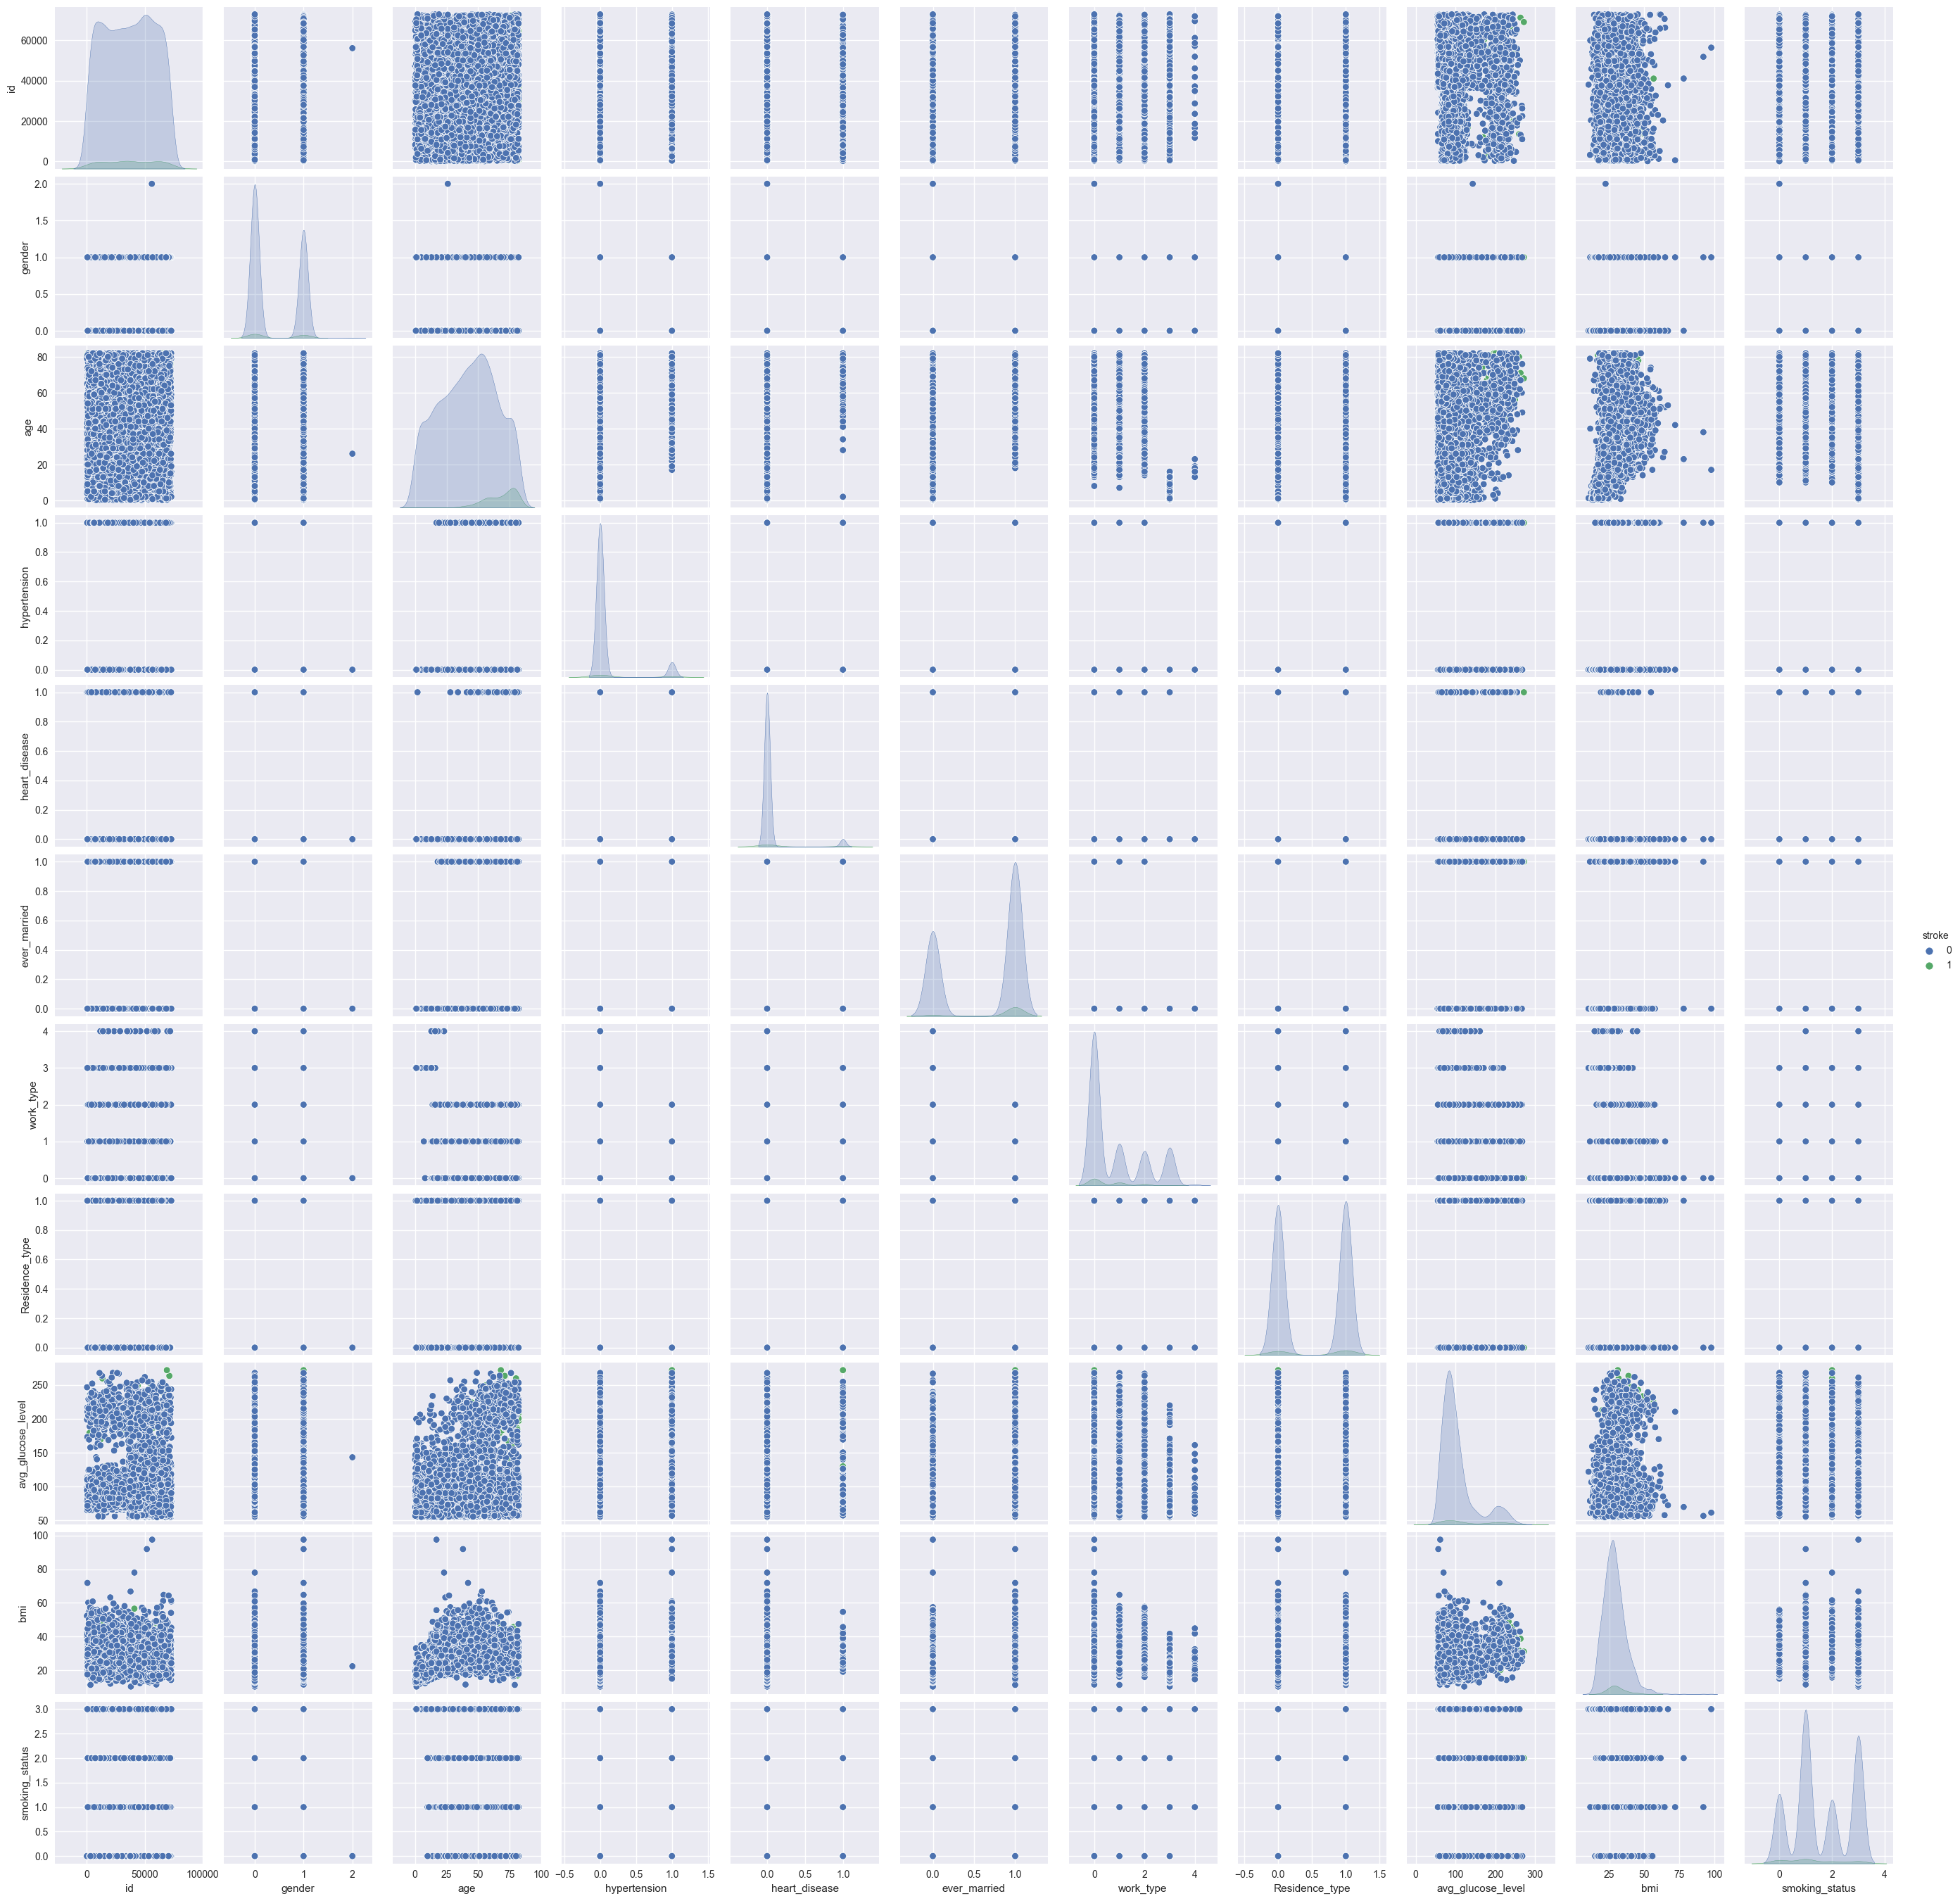

In [46]:
sns.pairplot(df_raw, hue='stroke')

/var/folders/r8/9_x5mqbs79gbpktlgmt3lyb40000gn/T/ipykernel_33271/877239918.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_raw.corr("pearson").round(3)


Text(0.5, 1.0, 'Pearson correlation')

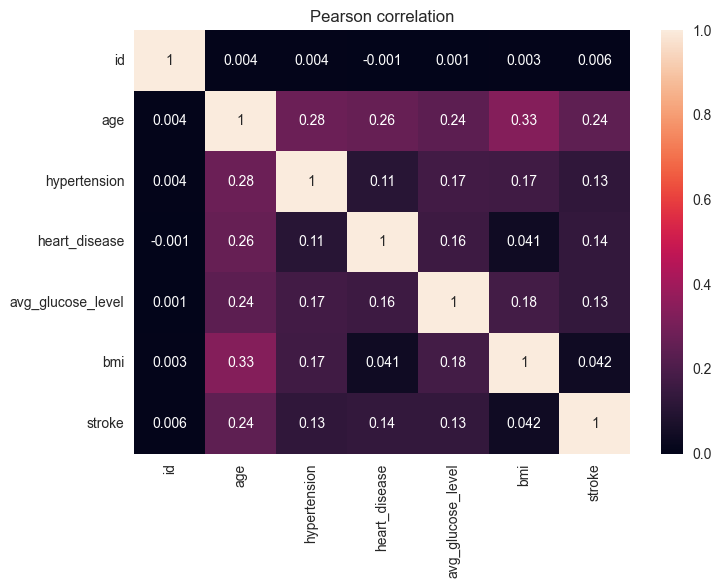

In [225]:
# make correlation plot
corr = df_raw.corr("pearson").round(3)
sns.heatmap(corr, annot=True)
plt.title("Pearson correlation")

<AxesSubplot: xlabel='age', ylabel='avg_glucose_level'>

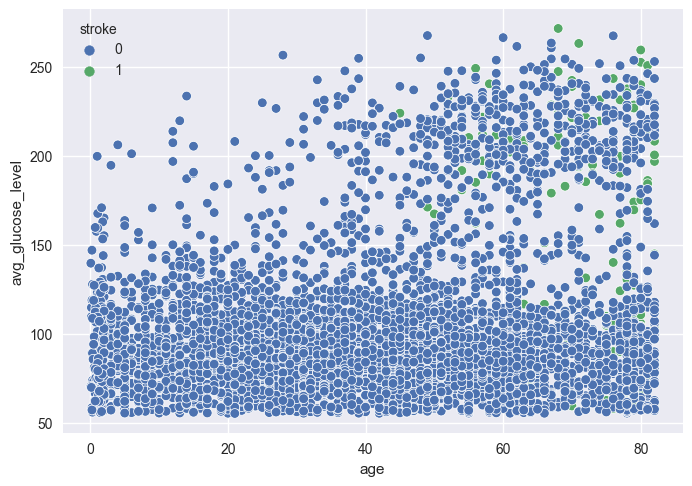

In [52]:
# make a scatter plot with seaborn
sns.scatterplot(data=df_raw, x="age", y="avg_glucose_level", hue="stroke")

# Preprocessing

In [ ]:
# Under sampling: Remove instance  from the overrepresented class (randomly)
# Over sampling: SMOTE (Synthetic Minority Over-sampling Technique)
# Ensemble methods (Random Forest, XGBoost, etc.) are naturally robust to imbalanced data

# create more features to help the model better predict stroke

In [81]:
df_raw = pd.read_csv("healthcare-dataset-stroke-data.csv")

# remove ID column
df_processed = df_raw.drop(columns=['id'])

# Change only record with gender "other" to majority value
df_processed.iloc[3116, 0] = df_raw['gender'].value_counts().idxmax()

# remove records with too low age
# the data contained a lot of records with age close to 0 ??
df_processed = df_processed[df_processed.age >= 10]

# Perform Undersampling to account for data imbalance
# randomly remove 80% of the non-stroke instances
df_processed = df_processed.drop(df_processed.query("stroke == 0").sample(frac=.8).index)

# Remove singe BMI outlier with BMI of 97,5
df_processed = df_processed[df_processed.bmi < 80]

# imputing missing values for BMI using KNN technique
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_processed['bmi'] = imputer.fit_transform(df_processed[['bmi']])

# Encode categorical variables as numbers
def encode_numericals(df: pd.DataFrame) -> pd.DataFrame:
    df_return = df.copy()
    df_return['ever_married'] = df_return['ever_married'].replace({'Yes': 1, 'No': 0})
    df_return['work_type'] = df_return['work_type'].replace({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})
    df_return['Residence_type'] = df_return['Residence_type'].replace({'Urban': 1, 'Rural': 0})
    df_return['smoking_status'] = df_return['smoking_status'].replace({'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3})
    df_return['gender'] = df_return['gender'].replace({"Female": 0, "Male": 1})
    return df_return
df_processed = encode_numericals(df_processed)

# perform oversampling using SMOTE
from imblearn.over_sampling import SMOTE
oversampling_ratio = 0.7 # can only be used for binary classification
smote = SMOTE(sampling_strategy=oversampling_ratio, k_neighbors=5, random_state=rs)
X = df_processed.drop(columns=['stroke'])
y = df_processed['stroke']
X_resampled, y_resampled = smote.fit_resample(X, y)
df_processed = pd.concat([X_resampled, y_resampled], axis=1)

unique, counts = np.unique(df_processed.stroke, return_counts=True)
print("Distribution of classes with synthetic data:")
print(dict(zip(("not stroke", "stroke"), counts)))

Distribution of classes with synthetic data:
{'not stroke': 845, 'stroke': 591}


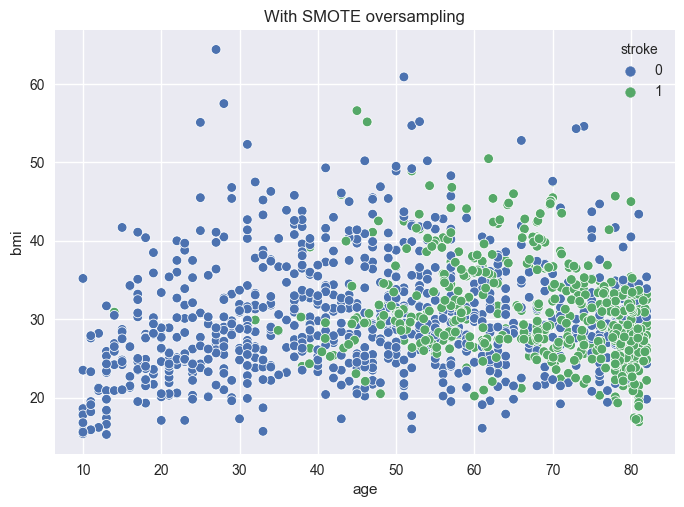

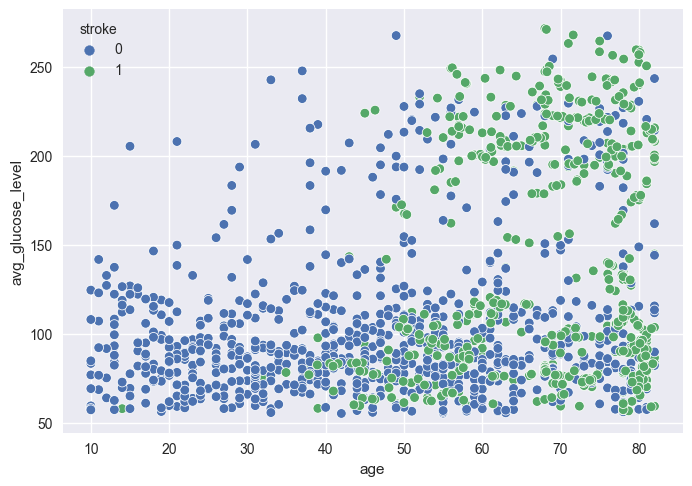

In [73]:
sns.scatterplot(data=df_processed, x="age", y="bmi", hue="stroke")
plt.title("With SMOTE oversampling")
plt.show()

sns.scatterplot(data=df_processed, x="age", y="avg_glucose_level", hue="stroke")
plt.show()

<AxesSubplot: xlabel='ever_married', ylabel='age'>

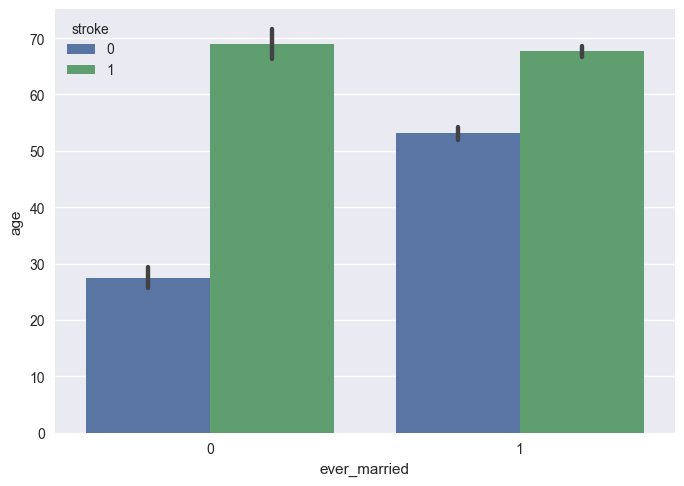

In [68]:
sns.barplot(data=df_processed, x="ever_married", y="age", hue="stroke")

Text(0.5, 1.0, 'Pearson correlation')

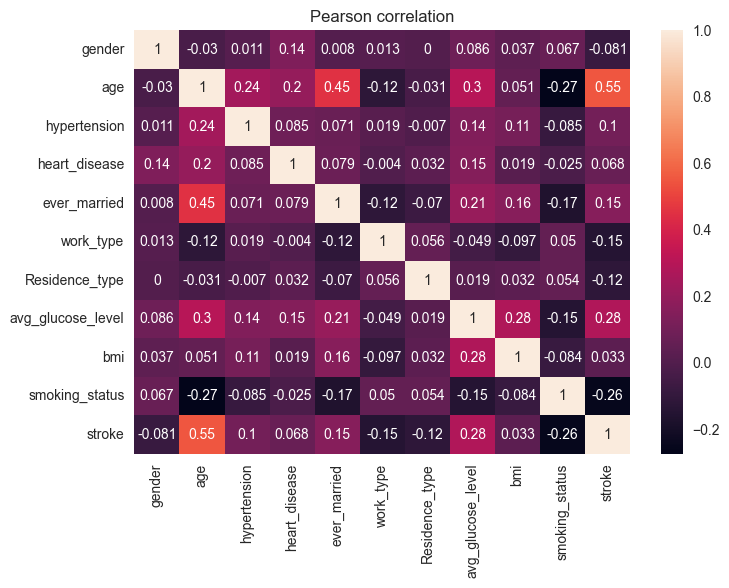

In [62]:
# make correlation plot
corr = df_processed.corr("pearson").round(3)
sns.heatmap(corr, annot=True)
plt.title("Pearson correlation")

# Model Training

In [82]:
# feature stanardisation for numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_processed[['age','avg_glucose_level', 'bmi']] = scaler.fit_transform(df_processed[['age', 'avg_glucose_level', 'bmi']])

df_processed.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,0.579748,0,1,1,0,1,1.979640,0.915701,0,1
1,1,1.233995,0,1,1,0,0,-0.218927,0.332563,1,1
2,0,-0.326132,0,0,1,0,1,0.950645,0.602797,2,1
3,0,1.183668,1,0,1,1,0,1.002400,-0.876381,1,1
4,1,1.284322,0,0,1,0,1,1.218908,-0.165238,0,1


In [83]:
# one hot encoding
categorical_variables = ['work_type', 'smoking_status']
df_processed = pd.get_dummies(df_processed, columns=categorical_variables, drop_first=True) # drop_first to avoid dummy variable trap.
df_processed.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_1,work_type_2,work_type_3,work_type_4,smoking_status_1,smoking_status_2,smoking_status_3
0,1,0.579748,0,1,1,1,1.979640,0.915701,1,0,0,0,0,0,0,0
1,1,1.233995,0,1,1,0,-0.218927,0.332563,1,0,0,0,0,1,0,0
2,0,-0.326132,0,0,1,1,0.950645,0.602797,1,0,0,0,0,0,1,0
3,0,1.183668,1,0,1,0,1.002400,-0.876381,1,1,0,0,0,1,0,0
4,1,1.284322,0,0,1,1,1.218908,-0.165238,1,0,0,0,0,0,0,0


Accuracy:  0.8194444444444444


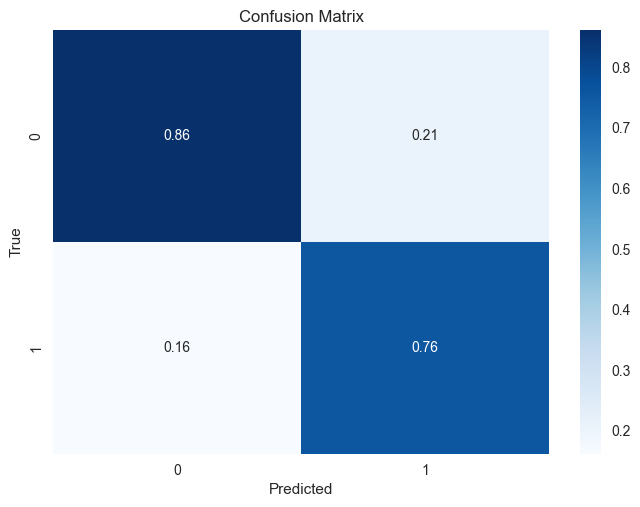

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       173
           1       0.78      0.76      0.77       115

    accuracy                           0.82       288
   macro avg       0.81      0.81      0.81       288
weighted avg       0.82      0.82      0.82       288



In [93]:
# split the data into train and test sets
from sklearn.model_selection import train_test_split

def train_rf_model(dataset, split_ratio: float = 0.2):
    X = dataset.drop(columns=['stroke'])
    y = dataset['stroke']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio)

    # fit a random forest classifier
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    # make predictions
    y_pred = clf.predict(X_test)

    # evaluate the model
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    print("Accuracy: ", accuracy_score(y_test, y_pred))

    # confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    cf_matrix = cf_matrix / cf_matrix.astype(float).sum(axis=1)
    sns.heatmap(cf_matrix, annot=True, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    print(classification_report(y_test, y_pred))

train_rf_model(df_processed)